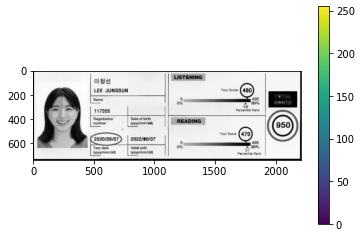

findMaxArea | took 0.000385 seconds.
process | took 3.315121 seconds.
mouse_callback | took 0.000004 seconds.
mouse_callback | took 0.000001 seconds.
mouse_callback | took 0.000004 seconds.
mouse_callback | took 0.000001 seconds.
mouse_callback | took 0.000004 seconds.
mouse_callback | took 0.000002 seconds.
mouse_callback | took 0.000004 seconds.
mouse_callback | took 0.000001 seconds.
mouse_callback | took 0.000004 seconds.
mouse_callback | took 0.000003 seconds.
mouse_callback | took 0.000003 seconds.
distance Between Two points | took 0.000007 seconds.
distance Between Two points | took 0.000003 seconds.
distance Between Two points | took 0.000002 seconds.
distance Between Two points | took 0.000002 seconds.
mouse_callback | took 0.000164 seconds.
mouse_callback | took 0.000007 seconds.
angle between | took 0.000084 seconds.
sort points | took 0.000449 seconds.
distance Between Two points | took 0.000002 seconds.
distance Between Two points | took 0.000003 seconds.
distance Between

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt



step = 0
mouse_is_pressing = False


def distanceBetweenTwoPoints(point1, point2):
    t0 = cv2.getTickCount()
    x1,y1 = point1
    x2,y2 = point2
    t1 = cv2.getTickCount()
    print ("distance Between Two points | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))
    return int(np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2)))


def mouse_callback(event,x,y,flags,param):
    global mouse_is_pressing,points
    t0 = cv2.getTickCount()
    if step != 1:
        return

    if event == cv2.EVENT_MOUSEMOVE: 
        if mouse_is_pressing == True: 
            for i,point in enumerate(points):
                if distanceBetweenTwoPoints((x,y), point) < 15:
                    points[i][0] = x
                    points[i][1] = y
                    break    
    elif event == cv2.EVENT_LBUTTONDOWN:
        for point in points:
            if distanceBetweenTwoPoints((x,y), point) < 10:
                mouse_is_pressing = True
                break

    elif event == cv2.EVENT_LBUTTONUP: 
        mouse_is_pressing = False
    t1 = cv2.getTickCount()
    print ("mouse_callback | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))


def angle_between(v0, v1):
    t0 = cv2.getTickCount()
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    t1 = cv2.getTickCount()
    print ("angle between | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))
    return np.degrees(angle)


def sort_points(points):
    t0 = cv2.getTickCount()
    points = points.astype(np.float32)

    rect = np.zeros((4, 2), dtype = "float32")
     # sort : top left, top right, bottom right, bottom left
    s = points.sum(axis = 1)
    min_index = np.argmin(s)
    rect[0] = points[min_index]
    points = np.delete(points, min_index, axis = 0)

    s = points.sum(axis = 1)
    max_index = np.argmax(s)
    rect[2] = points[max_index]
    points = np.delete(points, max_index, axis = 0)

    v0 = points[0] - rect[0]
    v1 = points[1] - rect[0]

    angle = angle_between(v0, v1)

    if angle < 0:
        rect[1] = points[1]
        rect[3] = points[0]
    else:
        rect[1] = points[0]
        rect[3] = points[1]
    t1 = cv2.getTickCount()
    print ("sort points | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))
    return rect


def transform(img_input, points):
    t0 = cv2.getTickCount()
    points = sort_points(points)
    topLeft, topRight, bottomRight, bottomLeft = points
    topWidth = distanceBetweenTwoPoints(bottomLeft, bottomRight)
    bottomWidth = distanceBetweenTwoPoints(topLeft, topRight)
    maxWidth = max(int(topWidth), int(bottomWidth))
    leftHeight = distanceBetweenTwoPoints(topLeft, bottomLeft)
    rightHeight = distanceBetweenTwoPoints(topRight, bottomRight)
    maxHeight = max(int(leftHeight), int(rightHeight))

    # top left, top right, bottom right, bottom left
    dst = np.array([[0, 0],[maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")
    H = cv2.getPerspectiveTransform(points, dst)
    img_warped = cv2.warpPerspective(img_input, H, (maxWidth, maxHeight))
    t1 = cv2.getTickCount()
    print ("transform | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))
    return img_warped


def findMaxArea(contours):
    t0 = cv2.getTickCount()
    max_contour = None
    max_area = -1
    for contour in contours:
        area = cv2.contourArea(contour)

    x,y,w,h = cv2.boundingRect(contour)

    if area > max_area:
        max_area = area
        max_contour = contour

    t1 = cv2.getTickCount()
    print ("findMaxArea | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))

    return max_area, max_contour

# process
def process(img_input, debug):
    t0 = cv2.getTickCount()
    points = []
    height,width =img_input.shape[:2]

    # Step 1    
    img_mask = np.zeros(img_input.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    
    
    # filter
#     img_input = cv2.GaussianBlur(img_input, (5,5), 0)

    rect = (5,5,width-10,height-10)
#     cv2.grabCut(img_input, img_mask, rect, bgdModel ,fgdModel,3,cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(img_input, img_mask, rect, bgdModel ,fgdModel,1,cv2.GC_INIT_WITH_RECT)
    img_mask = np.where((img_mask==2)|(img_mask==0), 0, 1).astype('uint8')
    img = img_input*img_mask[:,:,np.newaxis]
    
    plt.imshow(img),plt.colorbar(),plt.show()

    background = img_input - img

    background[np.where((background >= [0,0,0]).all(axis = 2))] = [0,0,0]

    img_grabcut = background + img

    if debug:
        cv2.imshow('grabCut', img_grabcut)


  # Step 2
    img_gray = cv2.cvtColor(img_grabcut, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_grabcut, 30, 90)

    if debug:
        cv2.imshow('Canny', img_canny)


    # Step 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img_canny = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, kernel, 1)

    if debug:
        cv2.imshow('morphology', img_canny)


    # Step 4
    contours, hierarchy = cv2.findContours(img_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    max_area, max_contour = findMaxArea(contours) 
    if max_area < 0:
        return points
    
    if debug:
        img_contour = img_input.copy()
        cv2.drawContours(img_contour, [max_contour], 0, (0, 0, 255), 3)
        cv2.imshow('Contour', img_contour)


    # Step 5
    max_contour = cv2.approxPolyDP(max_contour,0.02*cv2.arcLength(max_contour,True),True)
    hull = cv2.convexHull(max_contour)

    if debug:
        img_convexhull = img_input.copy()
        cv2.drawContours(img_convexhull, [hull], 0, (255,255,0), 5)
        cv2.imshow('convexHull', img_convexhull)


    # Step 6
    size = len(max_contour)

    if size == 4:
        for c in hull:
            points.append(tuple(c[0].tolist()))
        points=np.array(points)
        
    else:
        rect = cv2.minAreaRect(hull)
        box = cv2.boxPoints(rect)
        points = np.int0(box.tolist())

    found = False
    for p in points:
        if p[0] < 0 or p[0] > width-1 or p[1] < 0 or p[1] > height -1:
            found = True  
            break

    if found:
        points = np.array([[10,10], [width-11, 10], [width-11, height-11], [10, height-11]])
    t1 = cv2.getTickCount()
    print ("process | took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))
    return points
      

# img_input = cv2.imread('../app/static/img/cut_first_exact_dpi800/23.png',0)
img_input = cv2.imread('../app/static/img/train/gradecard/30.png',0)
# image_rs= cv2.resize(img_input, dsize=(0,0), fx=0.5, fy=0.5)
# img_save = cv2.imwrite('../app/static/img/cut_first_exact_dpi800/temp.jpg', img_input)
# img_input = cv2.imread('../app/static/img/cut_first_exact_dpi800/temp.jpg')
img_save = cv2.imwrite('../app/static/img/train/gradecard/temp.jpg', img_input)
img_input = cv2.imread('../app/static/img/train/gradecard/temp.jpg')
height, width = img_input.shape[:2]

points = process(img_input, debug=False)

size = len(points)

if size > 0:
    cv2.namedWindow('input')
    cv2.setMouseCallback("input", mouse_callback, 0)

    step = 1

    while True:
        img_result = img_input.copy()
        for point in points:
            cv2.circle(img_result, tuple(point), 10, (255,0,0), 3 )    
        cv2.imshow('input', img_result)

        key = cv2.waitKey(1)
        if key == 32:
            break


    img_final = transform(img_input, points )


    cv2.imshow('input', img_result)
    cv2.imshow('result', img_final )

else:
    cv2.imshow('input', img_input)

cv2.waitKey(0)
cv2.destroyAllWindows()